In [2]:
# export temporary ONNX model for TensorRT converter
!python3 export.py --weights ./yolov7_w6_safetyhelmet_epochs72_size1280_re.pt --grid --end2end --simplify --topk-all 100 --iou-thres 0.65 --conf-thres 0.5 --img-size 1280 1280 --dynamic-batch
!ls

Namespace(batch_size=1, conf_thres=0.5, device='cpu', dynamic=False, dynamic_batch=True, end2end=True, fp16=False, grid=True, img_size=[1280, 1280], include_nms=False, int8=False, iou_thres=0.65, max_wh=None, save_name='', simplify=True, topk_all=100, weights='./yolov7_w6_safetyhelmet_epochs72_size1280_re.pt')
YOLOR 🚀 v0.1-115-g072f76c torch 1.13.1+cu117 CPU

Fusing layers... 
/home/tekim/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 343 layers, 69794324 parameters, 69794324 gradients, 88.6 GFLOPS

Starting ONNX export with onnx 1.13.1...

Starting export end2end onnx model for TensorRT...
/home/tekim/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:675: UserWarning: The .grad attribute of a Tensor tha

In [7]:

!python3 YOLO-TensorRT8/build_engine.py -o ./yolov7_w6_safetyhelmet_epochs72_size1280_re.onnx -e ./yolov7_w6_safetyhelmet_epochs72_size1280_re.trt --fp16 --batch-size 1 16 32

YOLO-TensorRT8/build_engine.py:21: DeprecationWarning: Use set_memory_pool_limit instead.
  config.max_workspace_size = opt.workspace * 1 << 30
INFO:build_engine:
Network Description
******************************
Input 'images' with shape (-1, 3, 1280, 1280) and dtype DataType.FLOAT
Output 'num_dets' with shape (-1, 1) and dtype DataType.INT32
Output 'det_boxes' with shape (-1, 100, 4) and dtype DataType.FLOAT
Output 'det_scores' with shape (-1, 100) and dtype DataType.FLOAT
Output 'det_classes' with shape (-1, 100) and dtype DataType.INT32
******************************
INFO:build_engine:
dynamic batch profile is
        (1, 3, 1280, 1280)
        (16, 3, 1280, 1280)
        (32, 3, 1280, 1280)


In [1]:
import cv2
import torch
import random
import time
import numpy as np
import tensorrt as trt
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

In [2]:
w = './yolov7_w6_safetyhelmet_epochs72_size1280_re.trt'
device = torch.device('cuda:0')
imgList = [cv2.imread('./inference/images_sample/horses.jpg'),
           cv2.imread('./inference/images_sample/bus.jpg'),
           cv2.imread('./inference/images_sample/zidane.jpg'),
           cv2.imread('./inference/images_sample/image1.jpg'),
           cv2.imread('./inference/images_sample/image2.jpg'),
           cv2.imread('./inference/images_sample/image3.jpg')]
imgList*=6
imgList = imgList[:32]

In [3]:
# Infer TensorRT Engine
logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, namespace="")
with open(w, 'rb') as f, trt.Runtime(logger) as runtime:
    model = runtime.deserialize_cuda_engine(f.read())
context = model.create_execution_context()


def letterbox(im, new_shape=(1280,1280), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

def postprocess(boxes,r,dwdh):
    dwdh = torch.tensor(dwdh*2).to(boxes.device)
    boxes -= dwdh
    boxes /= r
    return boxes.clip_(0,6400)

names = ['hat','no_hat']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

[06/01/2023-15:03:54] [TRT] [I] Loaded engine size: 137 MiB
[06/01/2023-15:03:54] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +1914, GPU +342, now: CPU 2702, GPU 4871 (MiB)
[06/01/2023-15:03:55] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +1217, GPU +425, now: CPU 3919, GPU 5296 (MiB)
[06/01/2023-15:03:55] [TRT] [W] TensorRT was linked against cuDNN 8.8.0 but loaded cuDNN 8.5.0
[06/01/2023-15:03:55] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +133, now: CPU 0, GPU 133 (MiB)
[06/01/2023-15:03:55] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 3828, GPU 5298 (MiB)
[06/01/2023-15:03:55] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 3828, GPU 5306 (MiB)
[06/01/2023-15:03:55] [TRT] [W] TensorRT was linked against cuDNN 8.8.0 but loaded cuDNN 8.5.0
[06/01/2023-15:03:55] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +3801, now: CPU 0, GPU 3

In [4]:
origin_RGB = []
resize_data = []
for img in imgList:
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  origin_RGB.append(img)
  image = img.copy()
  image, ratio, dwdh = letterbox(image, auto=False)
  image = image.transpose((2, 0, 1))
  image = np.expand_dims(image, 0)
  image = np.ascontiguousarray(image)
  im = image.astype(np.float32)
  resize_data.append((im,ratio,dwdh))

In [5]:

DTYPE = {
    trt.DataType.FLOAT : torch.float32,
    trt.DataType.INT32 : torch.int32,
}
def getBindings(model,context,shape=(1,3,640,640)):
    context.set_binding_shape(0, shape)
    bindings = OrderedDict()
    Binding = namedtuple('Binding', ('name', 'dtype', 'shape', 'data', 'ptr'))
    
    for index in range(model.num_bindings):
        name = model.get_binding_name(index)
        dtype = trt.nptype(model.get_binding_dtype(index))
        shape = tuple(context.get_binding_shape(index))
        data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
        bindings[name] = Binding(name, dtype, shape, data, int(data.data_ptr()))
    return bindings


In [6]:
# warmup for 10 times
bindings = getBindings(model,context,(16,3,1280,1280))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
for _ in range(10):
    tmp = torch.randn(16,3,1280,1280).to(device)
    binding_addrs['images'] = int(tmp.data_ptr())
    context.execute_v2(list(binding_addrs.values()))
np_batch = np.concatenate([data[0] for data in resize_data])
np_batch.shape

/tmp/ipykernel_70162/2739898826.py:6: DeprecationWarning: Use set_input_shape instead.
  context.set_binding_shape(0, shape)
/tmp/ipykernel_70162/2739898826.py:11: DeprecationWarning: Use get_tensor_name instead.
  name = model.get_binding_name(index)
/tmp/ipykernel_70162/2739898826.py:12: DeprecationWarning: Use get_tensor_dtype instead.
  dtype = trt.nptype(model.get_binding_dtype(index))
/tmp/ipykernel_70162/2739898826.py:13: DeprecationWarning: Use get_tensor_shape instead.
  shape = tuple(context.get_binding_shape(index))


(32, 3, 1280, 1280)

In [7]:
np_batch = np.concatenate([data[0] for data in resize_data])
np_batch.shape

(32, 3, 1280, 1280)

In [8]:
# warmup for 10 times
bindings = getBindings(model,context,(16,3,1280,1280))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())

# for _ in range(10):
tmp = torch.randn(16,3,1280,1280).to(device)
binding_addrs['images'] = int(tmp.data_ptr())
context.execute_v2(list(binding_addrs.values()))

/tmp/ipykernel_70162/2739898826.py:6: DeprecationWarning: Use set_input_shape instead.
  context.set_binding_shape(0, shape)
/tmp/ipykernel_70162/2739898826.py:11: DeprecationWarning: Use get_tensor_name instead.
  name = model.get_binding_name(index)
/tmp/ipykernel_70162/2739898826.py:12: DeprecationWarning: Use get_tensor_dtype instead.
  dtype = trt.nptype(model.get_binding_dtype(index))
/tmp/ipykernel_70162/2739898826.py:13: DeprecationWarning: Use get_tensor_shape instead.
  shape = tuple(context.get_binding_shape(index))


True

In [9]:
# warmup for 10 times
bindings = getBindings(model,context,(32,3,1280,1280))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())

# for _ in range(10):
tmp = torch.randn(32,3,1280,1280).to(device)
binding_addrs['images'] = int(tmp.data_ptr())
context.execute_v2(list(binding_addrs.values()))

/tmp/ipykernel_70162/2739898826.py:6: DeprecationWarning: Use set_input_shape instead.
  context.set_binding_shape(0, shape)
/tmp/ipykernel_70162/2739898826.py:11: DeprecationWarning: Use get_tensor_name instead.
  name = model.get_binding_name(index)
/tmp/ipykernel_70162/2739898826.py:12: DeprecationWarning: Use get_tensor_dtype instead.
  dtype = trt.nptype(model.get_binding_dtype(index))
/tmp/ipykernel_70162/2739898826.py:13: DeprecationWarning: Use get_tensor_shape instead.
  shape = tuple(context.get_binding_shape(index))


True

In [10]:
batch_32 = torch.from_numpy(np_batch[0:32]).to(device)/255

bindings = getBindings(model,context,(32,3,1280,1280))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())

print("batch==32")
start = time.perf_counter()
binding_addrs['images'] = int(batch_32.data_ptr())
context.execute_v2(list(binding_addrs.values()))
print(f'Cost {time.perf_counter()-start} s')

batch==32
Cost 0.0800853420078056 s


/tmp/ipykernel_70162/2739898826.py:6: DeprecationWarning: Use set_input_shape instead.
  context.set_binding_shape(0, shape)
/tmp/ipykernel_70162/2739898826.py:11: DeprecationWarning: Use get_tensor_name instead.
  name = model.get_binding_name(index)
/tmp/ipykernel_70162/2739898826.py:12: DeprecationWarning: Use get_tensor_dtype instead.
  dtype = trt.nptype(model.get_binding_dtype(index))
/tmp/ipykernel_70162/2739898826.py:13: DeprecationWarning: Use get_tensor_shape instead.
  shape = tuple(context.get_binding_shape(index))


In [11]:
# show batch 32 output the first 6 pictures
nums = bindings['num_dets'].data
boxes = bindings['det_boxes'].data
scores = bindings['det_scores'].data
classes = bindings['det_classes'].data
nums.shape,boxes.shape,scores.shape,classes.shape

(torch.Size([32, 1]),
 torch.Size([32, 100, 4]),
 torch.Size([32, 100]),
 torch.Size([32, 100]))

In [14]:
nums

tensor([[0],
        [3],
        [3],
        [2],
        [3],
        [1],
        [0],
        [3],
        [3],
        [2],
        [3],
        [1],
        [0],
        [3],
        [3],
        [2],
        [3],
        [1],
        [0],
        [3],
        [3],
        [2],
        [3],
        [1],
        [0],
        [3],
        [3],
        [2],
        [3],
        [1],
        [0],
        [3]], device='cuda:0', dtype=torch.int32)

In [12]:
for batch,(num,box,score,cls) in enumerate(zip(nums.flatten(),boxes,scores,classes)):
    if batch>6:
        break
    RGB = origin_RGB[batch]
    ratio,dwdh = resize_data[batch][1:]
    box = postprocess(box[:num].clone(),ratio,dwdh).round().int()
    for idx,(b,s,c) in enumerate(zip(box,score,cls)):
        b,s,c = b.tolist(),round(float(s),3),int(c)
        name = names[c]
        color = colors[name]
        name += ' ' + str(s)
        cv2.rectangle(RGB,b[:2],b[2:],color,2)
        cv2.putText(RGB,name,(b[0], b[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,color,thickness=2)

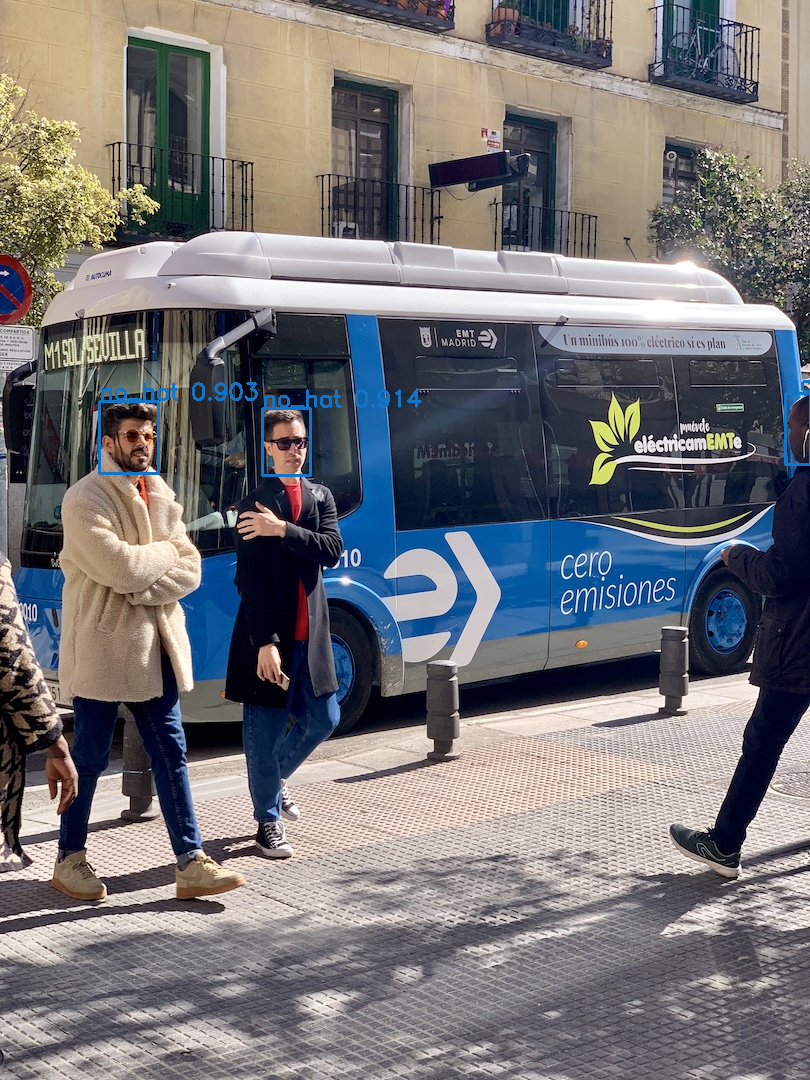

In [13]:
Image.fromarray(origin_RGB[1])